Nolan Roth <br>
PHYS 434 AC

# Lab #7

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import signal
from scipy.stats import norm
from astropy.table import QTable, Table, Column
from astropy import units as u
import numpy as np
import pickle

plt.rcParams["figure.figsize"] = (15, 10)

In [2]:
infile = open ('higgs_250_500.pkl','rb')
higgs_data = pickle.load(infile)
infile = open ('qcd_250_500.pkl', 'rb')
qcd_data = pickle.load(infile)

In [3]:
higgs_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

## Problem 1

Making a stacked histogram for Higgs mass data versus QCD mass data: 

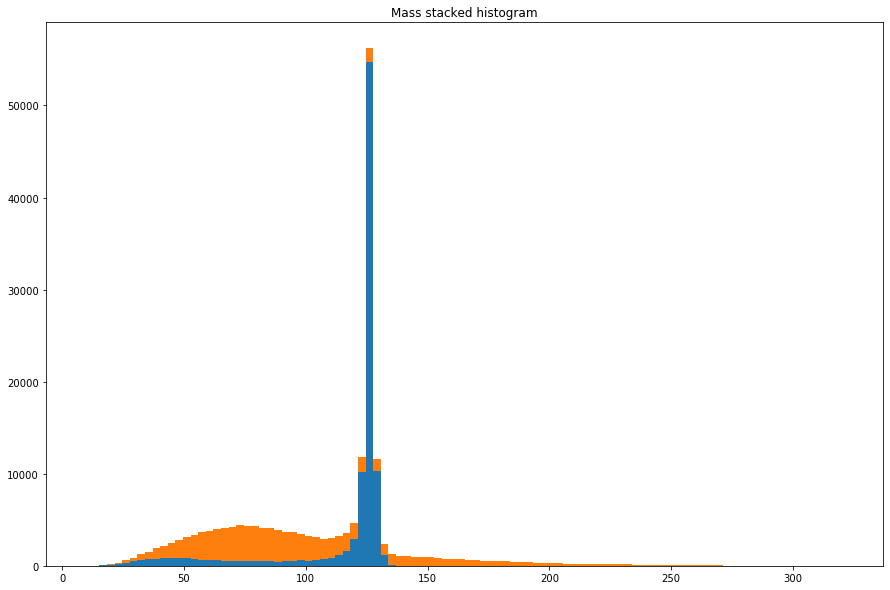

In [56]:
plt.hist([higgs_data['mass'], qcd_data['mass']], 100, stacked=True)
plt.title('Mass stacked histogram')
plt.show()

In [50]:
higgs_temp = higgs_data['mass'].values
higgs_events = higgs_temp[0:100]
qcd_temp = qcd_data['mass'].values
qcd_events = qcd_temp[0:20000]

Calculating the significance without any mass cuts:

In [51]:
print('Significance without any cuts: ' + str(stats.norm.ppf(stats.poisson.cdf(len(higgs_events) + len(qcd_events), len(qcd_events)))))
print('N(Higgs) / sqrt(N(QCD)) = ' + str(len(higgs_events)/(len(qcd_events))**(1/2)))

Significance without any cuts: 0.7112259282313185
N(Higgs) / sqrt(N(QCD)) = 0.7071067811865475


The significance value is very close to the value of N(Higgs) / sqrt(N(QCD)).

## Problem 2

In [52]:
def makeCut(lower, upper):
    cut_data = []
    higgs_count = 0
    qcd_count = 0
    for i in range(0, len(higgs_events)):
        if higgs_events[i] > lower and higgs_events[i] < upper:
            cut_data.append(higgs_events[i])
            higgs_count+=1
    for j in range(0, len(qcd_events)):
        if qcd_events[j] > lower and qcd_events[j] < upper:
            cut_data.append(qcd_events[j])
            qcd_count+=1
    return [cut_data, higgs_count, qcd_count]

Going forwards from 0 to 140 to find the optimal minimum for a mass cut:

In [35]:
max_sig = 0
max_lower = 0
for i in range(0, 140):
    higgs_count = makeCut(i, 140)[1]
    qcd_count = makeCut(i, 140)[2]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_lower = i
print(max_sig)
print(max_lower)

2.136171215771161
122


Going backwards from 140 to 122 to find the optimal maximum for a mass cut:

In [37]:
max_sig = 0
max_upper = 140
for i in range(0, 140 - max_lower):
    higgs_count = makeCut(max_lower, 140 - i)[1]
    qcd_count = makeCut(max_lower, 140 - i)[2]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_upper = 140 - i
print(max_sig)
print(max_upper)

3.049966001238351
128


So the optimal mass cut to maximize discovery significance is from 122 to 128.

## Problem 3

Stacked histograms for the rest of the variables:

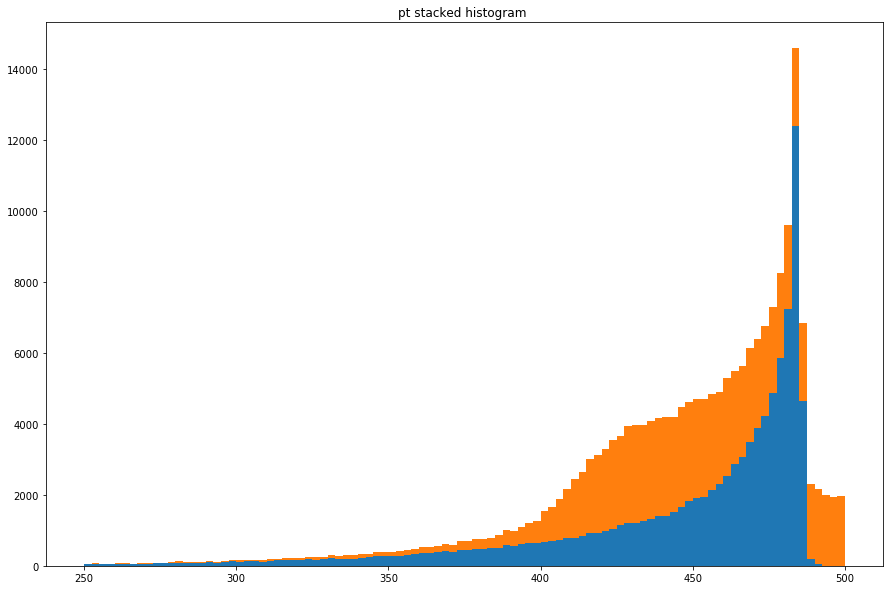

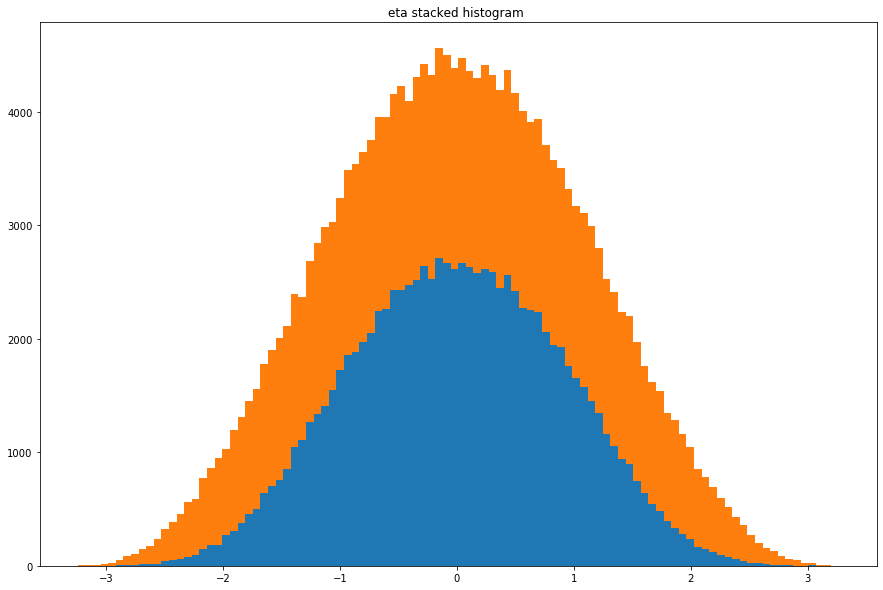

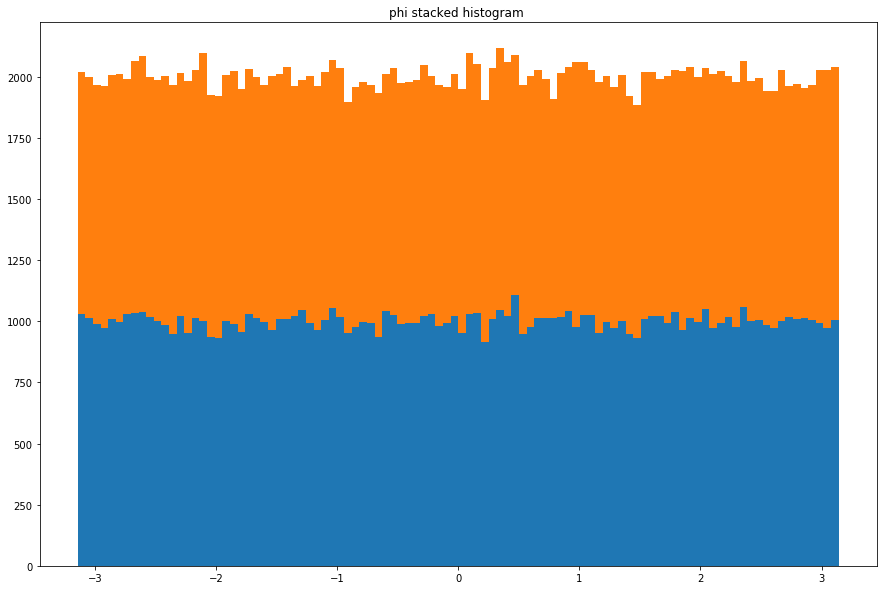

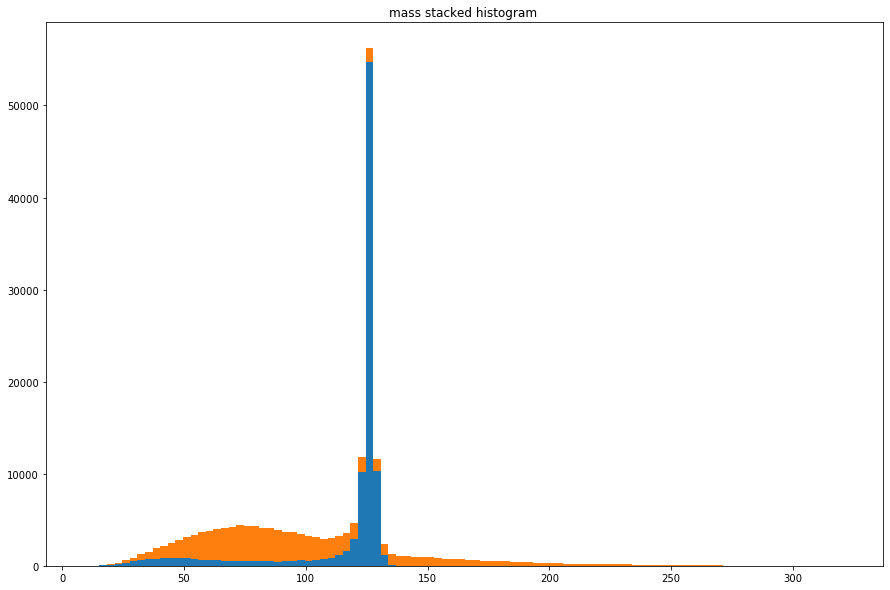

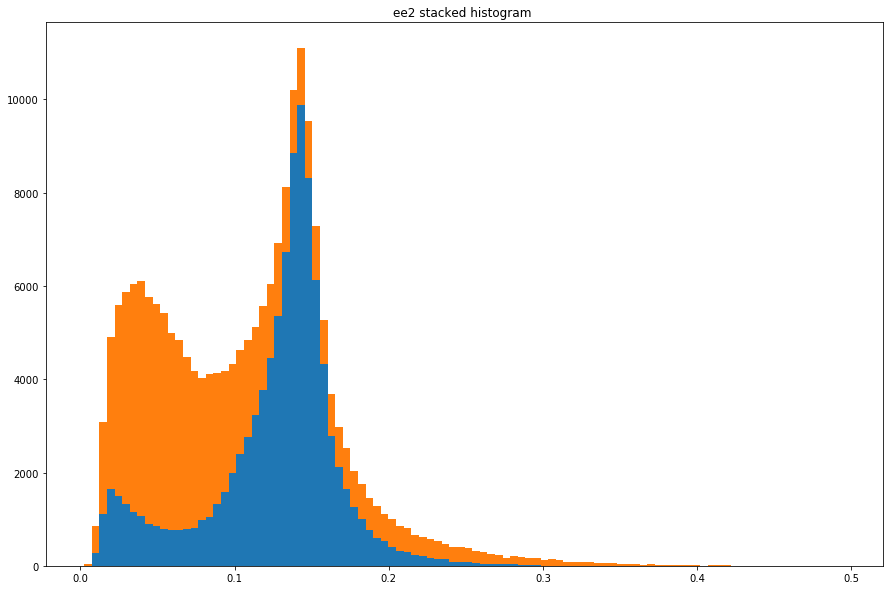

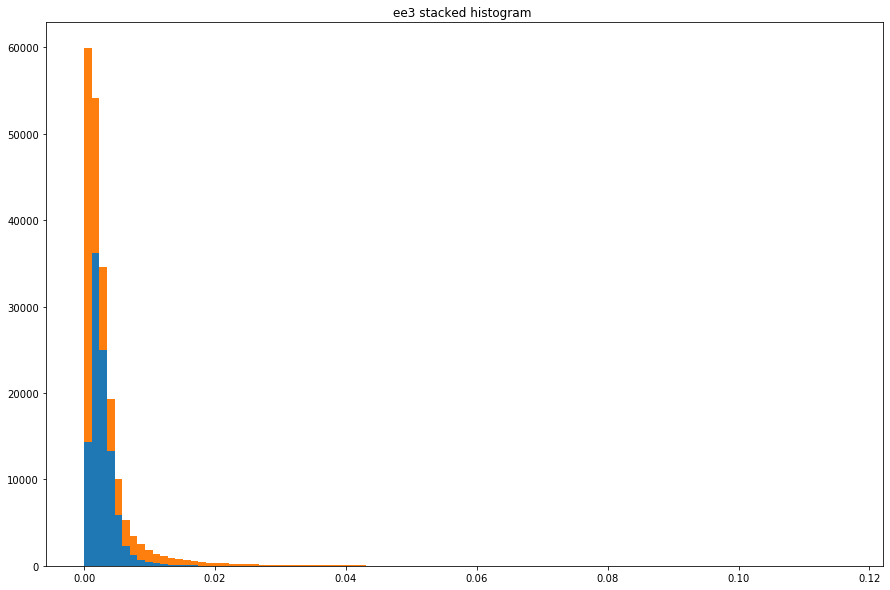

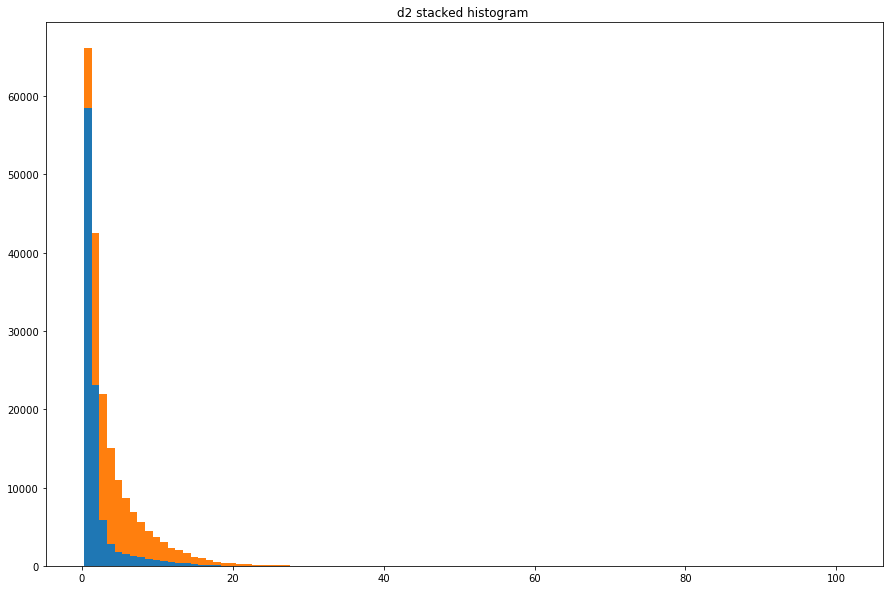

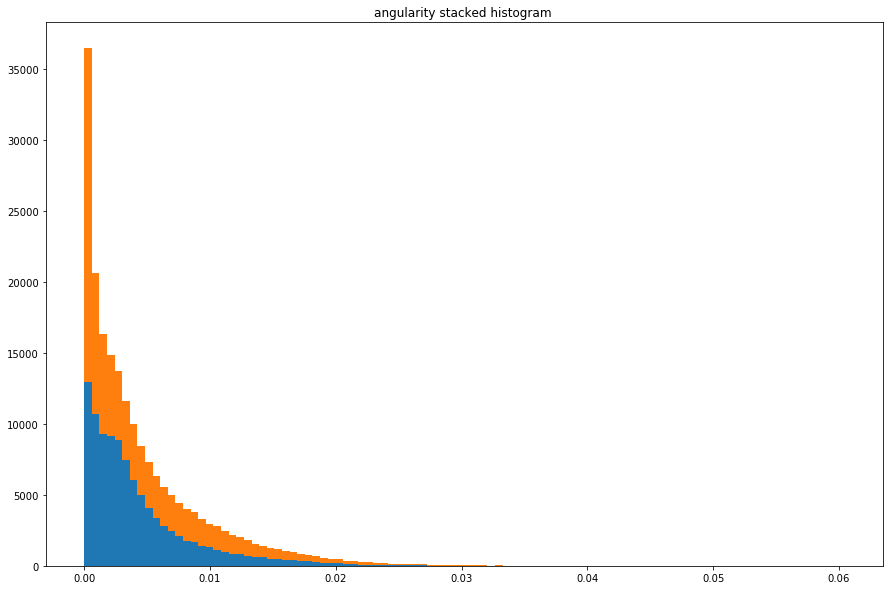

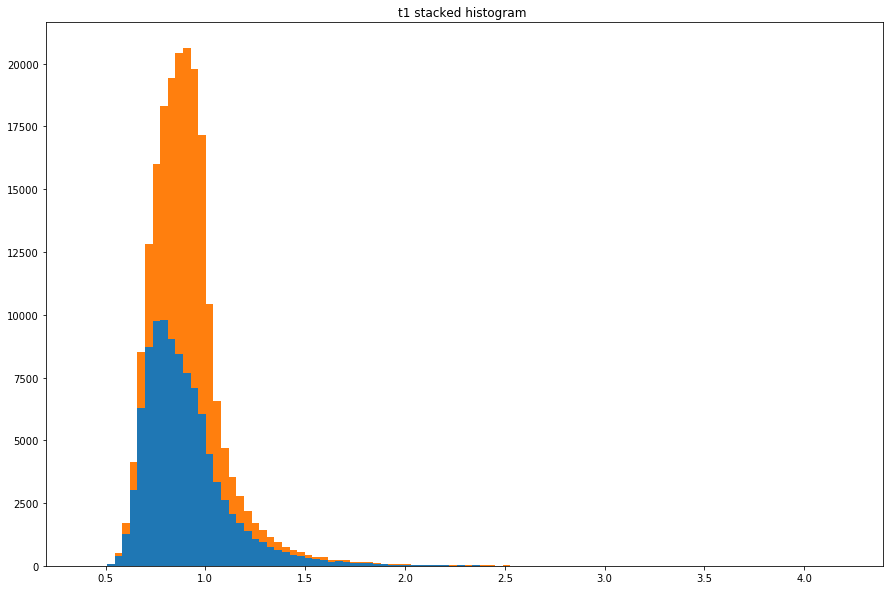

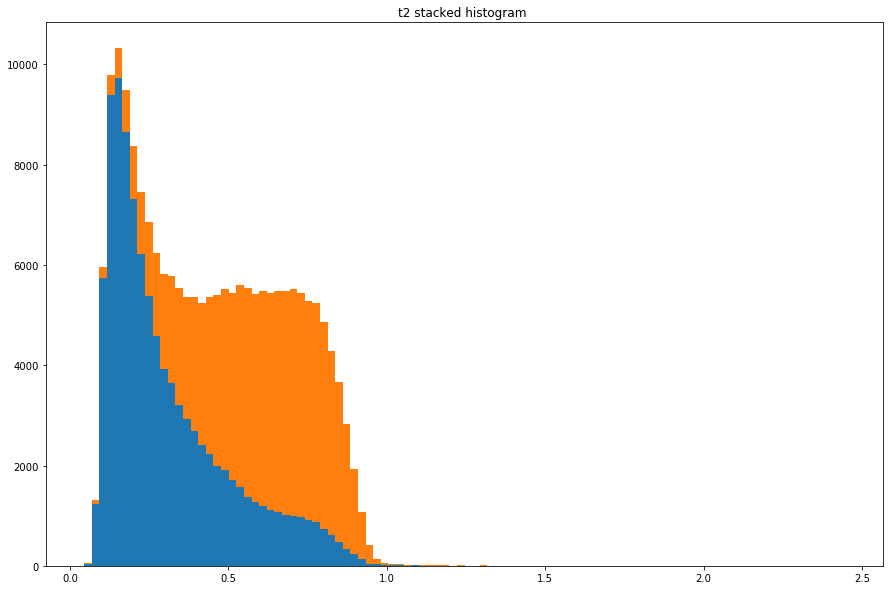

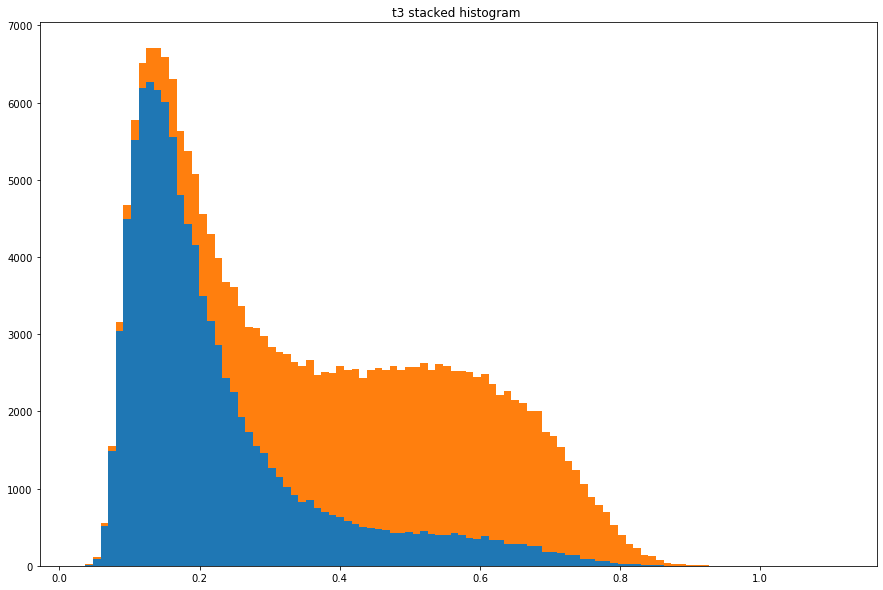

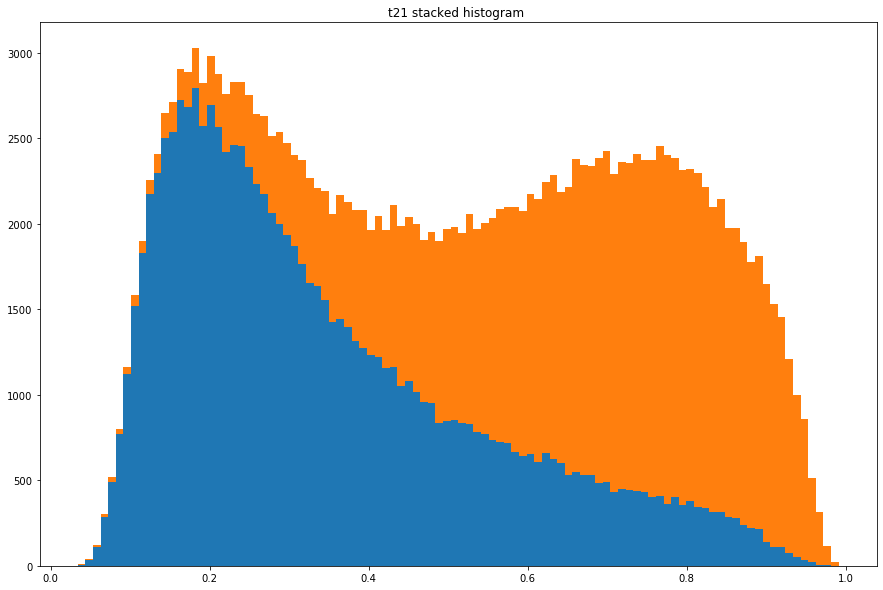

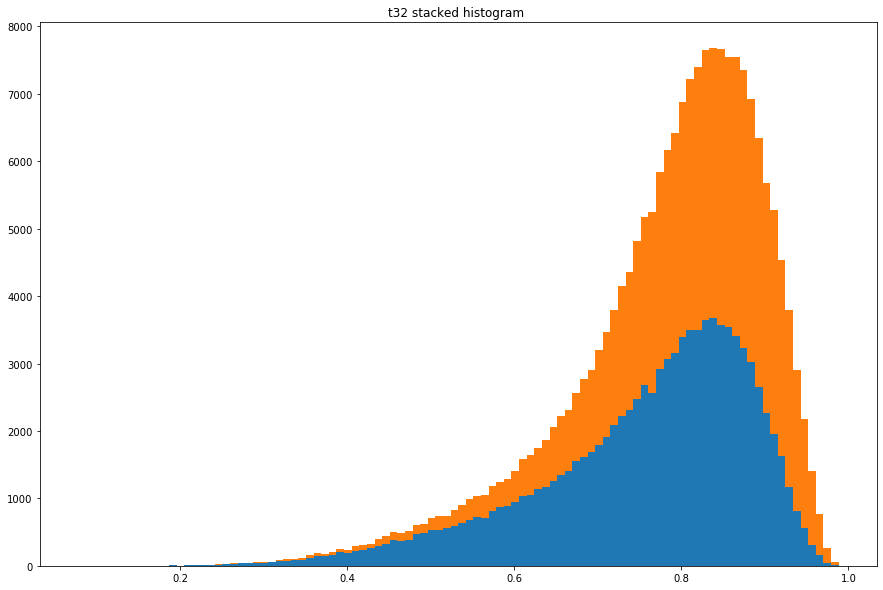

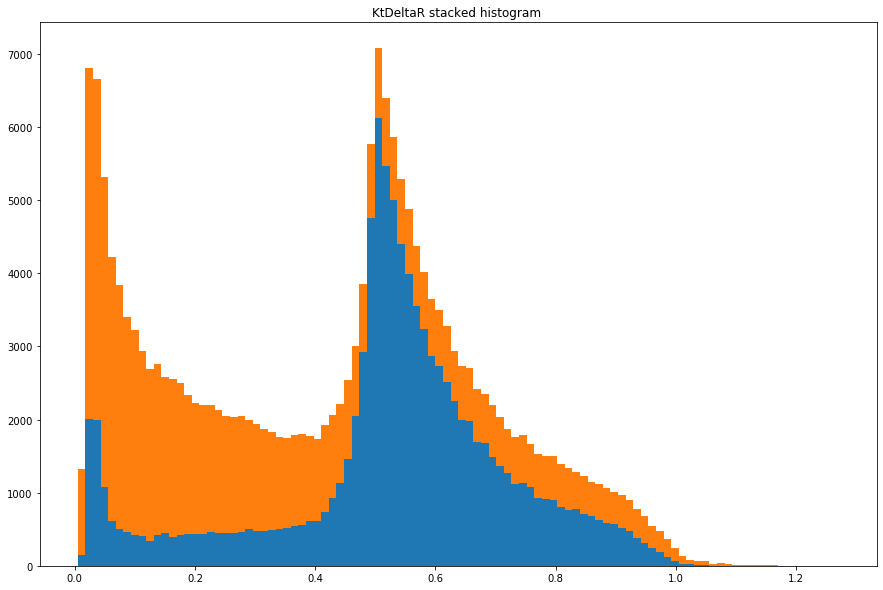

In [55]:
for key in higgs_data.keys():
    plt.hist([higgs_data[key], qcd_data[key]], 100, stacked=True)
    plt.title(str(key) + ' stacked histogram ')
    plt.show()